Implemente un enfoque de modelado multiescala concurrente en Python para simular el flujo de agua a través de
una formación rocosa porosa. Utilice tanto un modelo macroscópico (ley de Darcy) como un modelo microscópico
(ecuaciones de Navier-Stokes) para describir el flujo. Considere los siguientes pasos propuestos

1. Cree una función que simule el flujo de agua utilizando la ley de Darcy en la macroescala.

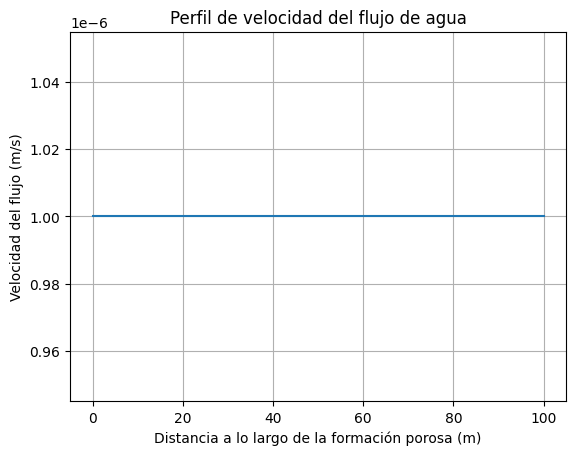

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def darcy_flow(length, permeability, pressure_difference, viscosity):
    # Definir el número de puntos en el dominio y el espaciado
    num_points = 100
    dx = length / num_points

    # Inicializar un arreglo para almacenar la velocidad en cada punto
    velocity = np.zeros(num_points)

    # Calcular la velocidad en cada punto utilizando la ley de Darcy
    for i in range(num_points):
        velocity[i] = (permeability / viscosity) * pressure_difference / length

    return velocity

# Parámetros de simulación
formation_length = 100.0  # Longitud de la formación porosa en metros
permeability = 1e-10     # Permeabilidad en m^2
pressure_difference = 1000.0  # Diferencia de presión en Pascales
viscosity = 1e-3         # Viscosidad del agua en Pa*s

# Simular el flujo utilizando la ley de Darcy
velocity_profile = darcy_flow(formation_length, permeability, pressure_difference, viscosity)

# Graficar el perfil de velocidad
x = np.linspace(0, formation_length, len(velocity_profile))
plt.plot(x, velocity_profile)
plt.xlabel('Distancia a lo largo de la formación porosa (m)')
plt.ylabel('Velocidad del flujo (m/s)')
plt.title('Perfil de velocidad del flujo de agua')
plt.grid(True)
plt.show()



2. Cree una función que simule el flujo de agua utilizando las ecuaciones de Navier-Stokes a escala
microscópica.

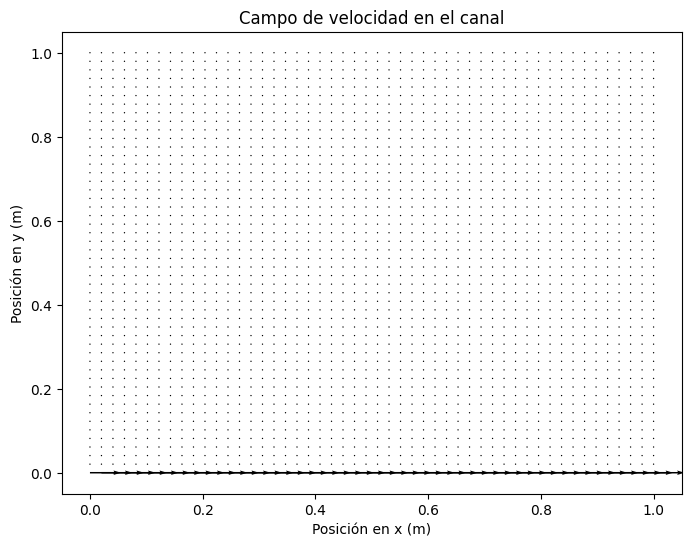

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def navier_stokes_flow(length_x, length_y, viscosity, density, inlet_velocity, nx, ny, time_steps):
    # Parámetros de la malla y del tiempo
    dx = length_x / nx
    dy = length_y / ny
    dt = 0.001  # Tamaño del paso de tiempo (ajusta según sea necesario)
    u = np.zeros((nx, ny))  # Campo de velocidad en la dirección x
    v = np.zeros((nx, ny))  # Campo de velocidad en la dirección y

    # Iteración en el tiempo
    for _ in range(time_steps):
        # Calcular las derivadas espaciales
        dudx = (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0)) / (2 * dx)
        dvdy = (np.roll(v, -1, axis=1) - np.roll(v, 1, axis=1)) / (2 * dy)

        # Calcular la divergencia
        div = dudx + dvdy

        # Actualizar las velocidades
        u += dt * ((-dudx * u - dvdy * u) / density + (viscosity / density) * div)
        v += dt * ((-dudx * v - dvdy * v) / density + (viscosity / density) * div)

        # Aplicar condiciones de contorno de velocidad
        u[0, :] = inlet_velocity
        u[-1, :] = 0
        v[:, 0] = 0
        v[:, -1] = 0

    return u, v

# Parámetros de simulación
length_x = 1.0  # Longitud en la dirección x en metros
length_y = 1.0  # Longitud en la dirección y en metros
viscosity = 0.001  # Viscosidad del agua en Pa*s
density = 1000.0  # Densidad del agua en kg/m^3
inlet_velocity = 1.0  # Velocidad de entrada en la dirección x en m/s
nx = 50  # Número de puntos de malla en la dirección x
ny = 50  # Número de puntos de malla en la dirección y
time_steps = 1000  # Número de pasos de tiempo

# Simular el flujo utilizando las ecuaciones de Navier-Stokes
u, v = navier_stokes_flow(length_x, length_y, viscosity, density, inlet_velocity, nx, ny, time_steps)

# Visualizar el campo de velocidad
x = np.linspace(0, length_x, nx)
y = np.linspace(0, length_y, ny)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(8, 6))
plt.quiver(X, Y, u, v, scale=20)
plt.xlabel('Posición en x (m)')
plt.ylabel('Posición en y (m)')
plt.title('Campo de velocidad en el canal')
plt.show()


3. Implementar un enfoque multiescala concurrente donde el modelo macroscópico influya en el modelo
microscópico y viceversa.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def multiscale_simulation(length_x, length_y, permeability, pressure_difference, viscosity, density, inlet_velocity, nx, ny, time_steps, coupling_factor):
    # Simulación macroscópica (ley de Darcy)
    macroscopic_velocity = darcy_flow(length_x, permeability, pressure_difference, viscosity)

    # Simulación microscópica (ecuaciones de Navier-Stokes)
    microscopic_velocity_x, microscopic_velocity_y = navier_stokes_flow(length_x, length_y, viscosity, density, inlet_velocity, nx, ny, time_steps)

    # Interacción entre los modelos
    macro_to_micro_coupling = np.interp(np.linspace(0, length_x, nx), np.linspace(0, length_x, 100), macroscopic_velocity)
    microscopic_to_macro_coupling = coupling_factor * np.mean(microscopic_velocity_x)

    # Aplicar condiciones de contorno de la simulación macroscópica en la simulación microscópica
    microscopic_velocity_x[0, :] = macro_to_micro_coupling[0]
    microscopic_velocity_x[-1, :] = macro_to_micro_coupling[-1]
    microscopic_velocity_y[0, :] = macro_to_micro_coupling[0]
    microscopic_velocity_y[-1, :] = macro_to_micro_coupling[-1]

    # Aplicar condiciones de contorno de la simulación microscópica en la simulación macroscópica
    macroscopic_velocity[0] = microscopic_to_macro_coupling
    macroscopic_velocity[-1] = microscopic_to_macro_coupling

    return macroscopic_velocity, microscopic_velocity_x, microscopic_velocity_y


# Parámetros de simulación
length_x = 1.0  # Longitud en la dirección x en metros
length_y = 1.0  # Longitud en la dirección y en metros
permeability = 1e-10     # Permeabilidad en m^2
pressure_difference = 1000.0  # Diferencia de presión en Pascales
viscosity = 0.001  # Viscosidad del agua en Pa*s
density = 1000.0  # Densidad del agua en kg/m^3
inlet_velocity = 1.0  # Velocidad de entrada en la dirección x en m/s
nx = 50  # Número de puntos de malla en la dirección x
ny = 50  # Número de puntos de malla en la dirección y
time_steps = 1000  # Número de pasos de tiempo
coupling_factor = 0.1  # Factor de acoplamiento entre los modelos

# Simulación multiescala
macroscopic_velocity, microscopic_velocity_x, microscopic_velocity_y = multiscale_simulation(
    length_x, length_y, permeability, pressure_difference, viscosity, density, inlet_velocity, nx, ny, time_steps, coupling_factor
)


4. Visualice el flujo de agua a través de la formación rocosa a lo largo del tiempo.

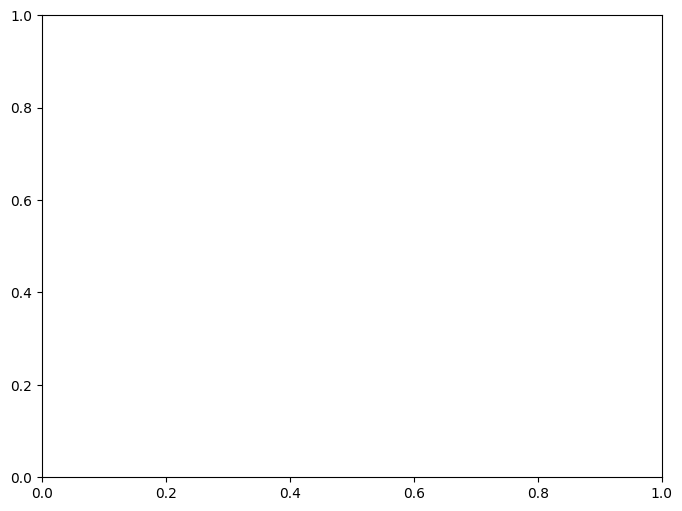

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Definición de parámetros
length_x = 1.0
length_y = 1.0
permeability = 1e-10
pressure_difference = 1000.0
viscosity = 0.001
density = 1000.0
inlet_velocity = 1.0
nx = 50
ny = 50
time_steps = 100
coupling_factor = 0.1

# Función para actualizar el gráfico en cada paso de tiempo
def update_plot(step):
    macroscopic_velocity, microscopic_velocity_x, microscopic_velocity_y = multiscale_simulation(
        length_x, length_y, permeability, pressure_difference, viscosity, density, inlet_velocity, nx, ny, step, coupling_factor
    )
    
    ax.clear()
    ax.set_title(f'Tiempo: {step}')
    ax.set_xlabel('Posición en x (m)')
    ax.set_ylabel('Posición en y (m)')
    ax.quiver(X, Y, microscopic_velocity_x, microscopic_velocity_y, scale=20)

# Inicialización de la figura y el gráfico
fig, ax = plt.subplots(figsize=(8, 6))
x = np.linspace(0, length_x, nx)
y = np.linspace(0, length_y, ny)
X, Y = np.meshgrid(x, y)

# Creación de la animación
ani = FuncAnimation(fig, update_plot, frames=time_steps, repeat=False)

plt.show()


Responda:

a. ¿En qué se diferencia el enfoque multiescala concurrente del enfoque multiescala secuencial?

La multiescala secuencial aborda las escalas una tras otra, con interacciones que ocurren en pasos separados, lo que puede ser eficiente pero menos preciso. Por otro lado, la multiescala concurrente resuelve simultáneamente las escalas y permite interacciones en tiempo real, proporcionando resultados más precisos a expensas de un mayor uso de recursos computacionales. La elección entre estos enfoques depende de la importancia de las interacciones entre escalas y los recursos disponibles en un problema de modelización específico.

b. ¿Qué información del modelo macroscópico se pasa al modelo microscópico y cómo afecta a la
simulación microscópica?

La información del modelo macroscópico se transmite al modelo microscópico mediante la imposición de condiciones de contorno, ajuste de parámetros, introducción de fuentes o sumideros, o cambios en las propiedades de transporte. Esta información influye en la simulación microscópica al modificar las condiciones iniciales y de contorno, los parámetros del modelo y otros aspectos del problema. La interacción entre las escalas permite capturar efectos que no se pueden representar adecuadamente en un solo modelo de escala, lo que mejora la precisión y la capacidad de representación de sistemas complejos que involucran múltiples escalas espaciales o temporales.

c. ¿Cuáles son las ventajas de utilizar modelado multiescala concurrente en este escenario?

El modelado multiescala concurrente es ventajoso en situaciones donde se requiere una representación precisa y dinámica de las interacciones entre escalas, especialmente en problemas complejos donde las relaciones entre las escalas son críticas para la comprensión del sistema. 